In [1]:

from tcn.tcn import  TemporalConvNet as TCN

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from sklearn.metrics import r2_score

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy as copy

In [4]:
from sklearn.preprocessing import StandardScaler

In [46]:
look_back = 50

In [1]:

win_size = 100  
forecast_horizon = 20  

In [48]:
save_dir = "../Image"

In [179]:
class TCN_net(nn.Module):
    def __init__(self, input_size, num_channels=[25], out_size=100,kernel_size=2, dropout=0.5):
        super(TCN_net, self).__init__()
        self.num_channels = num_channels
        self.tcn = TCN(num_inputs = input_size, num_channels = self.num_channels , kernel_size=2, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.linear = nn.Linear(in_features=self.num_channels[-1]*look_back, out_features=out_size, bias=True)
    def forward(self, x):
        x = x.permute(0,2,1)  
        x = self.tcn(x)
        # x = x.permute(0,2,1) 
        a, b, c = x.shape
        x = x.reshape(a,1, b*c)
        x = self.linear(x)

        return x

In [129]:
import random
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True  
     torch.backends.cudnn.enabled = True  
     torch.backends.cudnn.benchmark = True

setup_seed(0)

In [51]:
with open("../Data/train_x.pkl", "rb") as file:
    x_train = pickle.load(file)
# print(x_train)
with open("../Data/train_y.pkl", "rb") as file:
    y_train = pickle.load(file)
with open("../Data/test_x.pkl", "rb") as file:
    x_test = pickle.load(file)
with open("../Data/test_y.pkl", "rb") as file:
    y_test = pickle.load(file)

In [52]:
x_train.shape,x_test.shape

((9486, 463), (2042, 463))

In [53]:
y_train.shape,y_test.shape

((9486, 100), (2042, 100))

In [54]:
X = pd.concat([x_train,x_test])
y = pd.concat([y_train,y_test])
X.shape,y.shape

((11528, 463), (11528, 100))

In [55]:
col_1 = ["signed_side","size","price","grossValue","homeNotional","foreignNotional","Midprice_variance","Signed_trade_size_variance","Bid_ask_imbalance","Bid_ask_imbalance_muti","Bid_imbalance","Ask_imbalance","Volume_Order_Imbalance"]

In [56]:
col_2 = [f"Bid{i}" for i in range(10)]+[f"Bidsize{i}" for i in range(10)]+[f"Ask{i}" for i in range(10)]+[f"Asksize{i}" for i in range(10)]

In [57]:
X = X[col_1+col_2]

In [58]:
from sklearn.preprocessing import StandardScaler
scale_X = StandardScaler()
scale_X.fit(X)
scale_Y = StandardScaler()
scale_Y.fit(y)

StandardScaler()

In [59]:
X = scale_X.transform(X)
y = scale_Y.transform(y)

In [60]:
def set_data_seq(data_x,data_y,lookback):
    
    ans = []
    dataX, dataY = [], []
    for i in tqdm(range(lookback,len(data_x))):
        
        dataX.append(data_x[(i-lookback+1):(i+1)])
        dataY.append(data_y[(i):(i+1)])
    return dataX,dataY

In [61]:
X.shape

(11528, 53)

In [62]:
temp_X = X.copy()
temp_y = y.copy()
a ,b = set_data_seq(temp_X,temp_y,look_back)

100%|██████████| 11478/11478 [00:00<00:00, 963461.04it/s]


In [63]:
a,b = np.array(a), np.array(b)

In [64]:
with open('./a_50_short.pkl', 'wb') as file:
    pickle.dump(a, file)
with open('./b_50_short.pkl', 'wb') as file:
    pickle.dump(b, file)    

In [65]:
with open('a_50_short.pkl', 'rb') as file:
    a = pickle.load(file)
with open('b_50_short.pkl', 'rb') as file:
    b = pickle.load(file)

In [66]:
x_test.shape

(2042, 463)

In [304]:
x_train = a[:-2042,:,:].astype(float)
x_test = a[-2042:,:,:].astype(float)
y_train = b[:-2042,:,:].astype(float)
y_test = b[-2042:,:,:].astype(float)

In [305]:
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [69]:
batch_size = 64
train_data = TensorDataset(x_train,y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

In [330]:
def train_model(epoch, train_data, test_data):
    
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 1000
    epoch_cnt = 0
    for num in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_data, desc="Epoch:{}| Train Loss:{}| Test Loss:{}| Best Loss:{}".format(num, train_loss, test_loss,best_loss)):
            x = x.to(torch.float32)
            y = y.to(torch.float32)
            x = x.to(device=device)
            y = y.to(device=device)
            x_num = len(x)
            p = model_tcn(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
            
        train_loss = total_train_loss / total_train_num
        with torch.no_grad():
            for x, y in test_dataLoader:
                x = x.to(torch.float32)
                y = y.to(torch.float32)
                x = x.to(device=device)
                y = y.to(device=device)
                x_num = len(x)
                p = model_tcn(x)
                loss = loss_func(p, y)
                total_test_loss += loss.item()
                total_test_num += x_num
        test_loss = total_test_loss / total_test_num

        if best_loss > test_loss:
            best_loss = test_loss
            best_model = model_tcn
            epoch_cnt = 0
            torch.save(best_model.state_dict(),"./TCN_07_1.pth")
        else:
            epoch_cnt += 1

    torch.save(best_model.state_dict(),"./TCN_07_end.pth")


In [186]:
torch.cuda.set_device(1)

In [308]:

loss_func = nn.L1Loss()
model_tcn = TCN_net(x_train.shape[2])

optimizer = optim.Adam(model_tcn.parameters(), lr=0.0001,weight_decay= 0.000001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
torch.cuda.set_device(1)

model_tcn = model_tcn.to(device = device)

In [346]:

optimizer = optim.Adam(model_tcn.parameters(), lr=0.001,weight_decay= 0.00001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model_tcn.train()
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
epoch = 70
train_model(epoch, train_dataLoader, test_dataLoader)

Epoch:0| Train Loss:0| Test Loss:0| Best Loss:1000: 100%|██████████| 148/148 [00:01<00:00, 78.92it/s]
Epoch:1| Train Loss:0.00836038189786579| Test Loss:0.009297652751207352| Best Loss:0.009297652751207352: 100%|██████████| 148/148 [00:01<00:00, 80.92it/s]
Epoch:2| Train Loss:0.008437347147122638| Test Loss:0.009615788549184798| Best Loss:0.009297652751207352: 100%|██████████| 148/148 [00:01<00:00, 79.23it/s]
Epoch:3| Train Loss:0.00834097129250543| Test Loss:0.010163365989923477| Best Loss:0.009297652751207352: 100%|██████████| 148/148 [00:01<00:00, 81.21it/s]
Epoch:4| Train Loss:0.008402360068660209| Test Loss:0.010097401559352875| Best Loss:0.009297652751207352: 100%|██████████| 148/148 [00:01<00:00, 78.17it/s]
Epoch:5| Train Loss:0.008269202407890076| Test Loss:0.010001377880573273| Best Loss:0.009297652751207352: 100%|██████████| 148/148 [00:01<00:00, 79.57it/s]
Epoch:6| Train Loss:0.008059469279456109| Test Loss:0.01025640046596527| Best Loss:0.009297652751207352: 100%|██████████

KeyboardInterrupt: 

In [303]:
# 加入惩罚项
optimizer = optim.Adam(model_tcn.parameters(), lr=0.0001,weight_decay= 0.00001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model_tcn.train()
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
epoch = 70
train_model(epoch, train_dataLoader, test_dataLoader)

Epoch:0| Train Loss:0| Test Loss:0| Best Loss:1000: 100%|██████████| 148/148 [00:01<00:00, 78.02it/s]
Epoch:1| Train Loss:0.008969384210437675| Test Loss:0.009473928570747376| Best Loss:0.009473928570747376: 100%|██████████| 148/148 [00:01<00:00, 77.21it/s]
Epoch:2| Train Loss:0.008747445473912511| Test Loss:0.009827474653720856| Best Loss:0.009473928570747376: 100%|██████████| 148/148 [00:01<00:00, 85.27it/s]
Epoch:3| Train Loss:0.008547264239314553| Test Loss:0.010238257616758346| Best Loss:0.009473928570747376: 100%|██████████| 148/148 [00:01<00:00, 79.67it/s]
Epoch:4| Train Loss:0.008438111752296919| Test Loss:0.010641017973423005| Best Loss:0.009473928570747376: 100%|██████████| 148/148 [00:01<00:00, 86.47it/s]
Epoch:5| Train Loss:0.008365595685622104| Test Loss:0.010903141826391221| Best Loss:0.009473928570747376: 100%|██████████| 148/148 [00:01<00:00, 85.70it/s]
Epoch:6| Train Loss:0.008303663219219045| Test Loss:0.011127496033906937| Best Loss:0.009473928570747376: 100%|███████

KeyboardInterrupt: 

In [264]:
model_tcn = TCN_net(x_train.shape[2])

model_tcn = model_tcn.to(device = device)

## Score

In [366]:
import numpy as np

In [413]:

model_tcn.load_state_dict(torch.load("././TCN_07_best123.pth"))

<All keys matched successfully>

In [414]:
model_tcn.eval()
ans = np.empty([0,100])
for x, _ in test_dataLoader:
    x = x.to(torch.float32)
    x = x.to(device)
    x_num = len(x)
    p = model_tcn(x)
    q = p.squeeze(1).to("cpu").detach().numpy()
    # print(p.shape)
    # break
    ans = np.concatenate((ans, q), axis=0)

In [415]:
ans.shape,y_test.shape

((1000, 100), torch.Size([1000, 1, 100]))

In [416]:
from sklearn.metrics import r2_score

In [417]:
temp = y_test.numpy().copy()
temp = np.squeeze(temp)
temp.shape

(1000, 100)

In [418]:
from sklearn.metrics import r2_score

In [419]:
temp.shape,ans.shape

((1000, 100), (1000, 100))

In [420]:
temp

array([[-0.76124111, -0.47694362, -0.3533822 , ...,  0.98381051,
         0.98084288,  0.97832422],
       [ 0.20874824,  0.30638243,  0.43579029, ...,  1.15409521,
         1.15039275,  1.14722473],
       [ 0.14616828,  0.25235994, -0.39420147, ...,  1.10891764,
         1.10541013,  1.10241439],
       ...,
       [-0.99591595, -1.12521345, -1.02009689, ..., -0.91364757,
        -0.83230274, -0.66587059],
       [-0.30753641, -0.1528087 , -0.25813725, ..., -0.61478054,
        -0.44822037, -0.20053243],
       [ 0.13052329,  0.00925875,  0.0139912 , ..., -0.38194228,
        -0.13334202, -0.29360006]])

In [421]:
ans

array([[-0.1027474 , -0.49209726, -0.45062894, ...,  0.66315067,
         0.65848726,  0.66807449],
       [-0.1220504 , -0.26250467, -0.32033437, ...,  0.83303154,
         0.81186199,  0.79909718],
       [ 0.06320693, -0.13788249, -0.38392824, ...,  0.81669295,
         0.81269926,  0.85553229],
       ...,
       [ 0.00487914, -0.01126045, -0.33271706, ..., -0.30689365,
        -0.34697366, -0.35147655],
       [ 0.0460107 , -0.10463536, -0.36965865, ..., -0.35906866,
        -0.38650376, -0.47295231],
       [-0.08364459, -0.35116181, -0.60976774, ..., -0.47750196,
        -0.47711372, -0.60088724]])

In [422]:
r2_score(temp[:,0],ans[:,0])

0.09294455485526798

In [423]:
ans_r2_test = [0]*100
for i in tqdm(range(100)):
    y_pre = ans[:,i]
    y_true= temp[:,i]
    ans_r2_test[i] = r2_score(y_true,y_pre)

100%|██████████| 100/100 [00:00<00:00, 4047.70it/s]


In [424]:
max(ans_r2_test)

0.28780381749029305

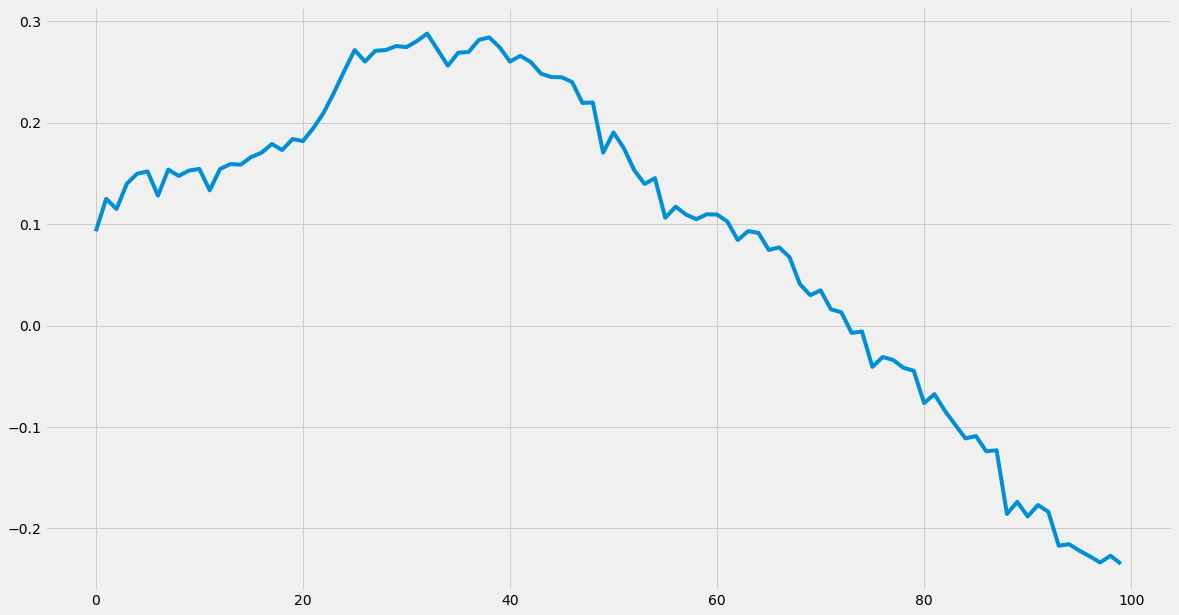

In [425]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(18,10))
    plt.plot(ans_r2_test[:])
    # plt.plot(ans_r2_test)
    fig_file = os.path.join(save_dir, "TCN.png")
    plt.savefig(fig_file, dpi=600, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(fig_file.replace('.png', '.tif'), dpi=600, bbox_inches='tight', pad_inches=0.2,
                pil_kwargs={"compression": "tiff_lzw"})
    plt.savefig(fig_file.replace('.png', '.svg'), format='svg', bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [359]:
import matplotlib.pyplot as plt
import matplotlib
import os
save_dir = "./Image"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'  

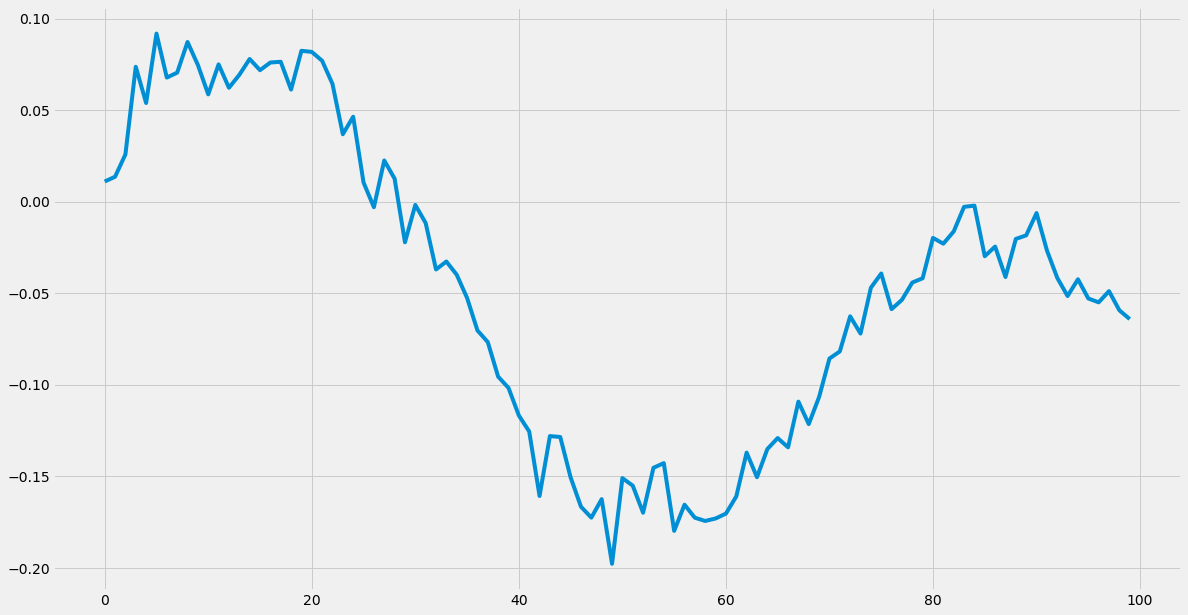

In [363]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(18,10))
    plt.plot(ans_r2_test[:])
    # plt.plot(ans_r2_test)
    fig_file = os.path.join(save_dir, "TCN.png")
    plt.savefig(fig_file, dpi=600, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(fig_file.replace('.png', '.tif'), dpi=600, bbox_inches='tight', pad_inches=0.2,
                pil_kwargs={"compression": "tiff_lzw"})
    plt.savefig(fig_file.replace('.png', '.svg'), format='svg', bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [361]:
with open('./TCNresult.pkl', 'wb') as file:
    pickle.dump(ans_r2_test, file)